In [79]:
from ydata_profiling import ProfileReport
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 


RANDOM_STATE = 42

In [80]:
secondary_mushroom = fetch_ucirepo(id=848) 

X = secondary_mushroom.data.features 
y = secondary_mushroom.data.targets 

print(secondary_mushroom.metadata) 
print(secondary_mushroom.variables) 


{'uci_id': 848, 'name': 'Secondary Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/848/data.csv', 'abstract': 'Dataset of simulated mushrooms for binary classification into edible and poisonous.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 61068, 'num_features': 20, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2021, 'last_updated': 'Wed Apr 10 2024', 'dataset_doi': '10.24432/C5FP5Q', 'creators': ['Dennis Wagner', 'D. Heider', 'Georges Hattab'], 'intro_paper': {'title': 'Mushroom data creation, curation, and simulation to support classification tasks', 'authors': 'Dennis Wagner, D. Heider, Georges Hattab', 'published_in': 'Scientific Reports', 'year': 2021, 'url': 'https://www.semanticscholar.org/

In [81]:
data = pd.DataFrame(X)
data['target'] = y

In [83]:
profile = ProfileReport(data, title='Pandas Profiling Report', explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Conclusion after EDA:
- 120 duplicates
- dataset is balanced 
- some columns have missing values greater than 40% we will drop them:
    - stem-root
    - stem-surface
    - veil-type
    - veil-color
    - spore-print-color
    - gill-spacing
- other missing values will be impured
- we have a lot of correlated features, maybe some reduction of dimensionality???
- take care of categorical features / numerical features


In [84]:
data = data.drop_duplicates()
columns_to_drop = ['stem-root', 'stem-surface', 'veil-type', 'veil-color', 'spore-print-color', 'gill-spacing']
data = data.drop(columns=columns_to_drop)

In [85]:
numeric_features = ['cap-diameter', 'stem-height', 'stem-width']
categorical_features = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed',
       'gill-attachment', 'gill-color', 'stem-color', 'has-ring', 'ring-type',
       'habitat', 'season']

In [86]:
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier


numeric_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_onehot_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

categorical_label_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

preprocessor_oh = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_onehot_pipeline, categorical_features)
])

preprocessor_l = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_label_pipeline, categorical_features)
])

clf_oh = Pipeline(steps=[
    ('preprocessor', preprocessor_oh),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

clf_l = Pipeline(steps=[
    ('preprocessor', preprocessor_l),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# clf_kbest = Pipeline(steps=[
#     ('preprocessor', preprocessor_l),
#     ('kbest', SelectKBest(k=10)),
#     ('model', DecisionTreeClassifier(random_state=42))
# ])

In [87]:
def map_target(x):
    if x == 'p' or x == 1:
        return 1
    elif x == 'e' or x == 0:
        return 0
    
print(data['target'].unique())

data['target'] = data['target'].apply(lambda x: map_target(x))

print(data['target'].unique())

['p' 'e']
[1 0]


- P is 1
- E is 0

In [88]:
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__ccp_alpha': [0.0, 0.1, 0.2],
    'model__class_weight': [None, {1: 3, 0: 1}]
}


In [89]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

X = data.drop(columns='target')
y = data['target']

results = []
for clf in [clf_oh, clf_l]:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    search = GridSearchCV(clf, param_grid, cv=cv, n_jobs=-1, verbose=1, scoring='f1')
    search.fit(X, y)
    results.append(search)
    print(search.best_params_)
    print(search.best_score_)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
{'model__ccp_alpha': 0.0, 'model__class_weight': {1: 3, 0: 1}, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'preprocessor__num__imputer__strategy': 'mean'}
0.9972151939171354
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
{'model__ccp_alpha': 0.0, 'model__class_weight': None, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'preprocessor__num__imputer__strategy': 'mean'}
0.9958942921716204


In [90]:
for result, name in zip(results, ['OneHot', 'Label']):
    print(name)
    print(result.best_params_)
    print(result.best_score_)

OneHot
{'model__ccp_alpha': 0.0, 'model__class_weight': {1: 3, 0: 1}, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'preprocessor__num__imputer__strategy': 'mean'}
0.9972151939171354
Label
{'model__ccp_alpha': 0.0, 'model__class_weight': None, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'preprocessor__num__imputer__strategy': 'mean'}
0.9958942921716204


In [93]:
result_oh = results[0]

all_results = pd.DataFrame(result_oh.cv_results_)
all_results = all_results.sort_values(by='rank_test_score')
print(all_results.columns)
all_results = all_results[all_results['param_model__class_weight'] != {1: 3, 0: 1}]

print(all_results['mean_test_score'][0])

all_results.head(2)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__ccp_alpha', 'param_model__class_weight',
       'param_model__criterion', 'param_model__max_depth',
       'param_model__min_samples_leaf', 'param_model__min_samples_split',
       'param_preprocessor__num__imputer__strategy', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')
0.9963244368469916


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__ccp_alpha,param_model__class_weight,param_model__criterion,param_model__max_depth,param_model__min_samples_leaf,param_model__min_samples_split,param_preprocessor__num__imputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
75,1.514349,0.040660,0.083999,0.018644,0.0,None,entropy,None,1,5,median,"{'model__ccp_alpha': 0.0, 'model__class_weight...",0.995997,0.996371,0.996152,0.997628,0.997258,0.996681,0.000644,11
74,1.556804,0.093559,0.085126,0.013584,0.0,None,entropy,None,1,5,mean,"{'model__ccp_alpha': 0.0, 'model__class_weight...",0.995997,0.996371,0.996152,0.997628,0.997258,0.996681,0.000644,11


In [118]:
names = [f'param_{x}' for x in param_grid.keys()]
all_results = pd.DataFrame(result_oh.cv_results_)

all_results.loc[all_results['param_model__class_weight'].isnull(), 'param_model__class_weight'] = 'None'
all_results.loc[all_results['param_model__class_weight'] == {1: 3, 0: 1}, 'param_model__class_weight'] = '1:3, 0:1'

all_results.loc[all_results['param_model__max_depth'].isnull(), 'param_model__max_depth'] = 'None'




for name in names:
    print(all_results.groupby(name)['mean_test_score'].mean())



param_preprocessor__num__imputer__strategy
mean      0.77483
median    0.77483
Name: mean_test_score, dtype: float64
param_model__criterion
entropy    0.774561
gini       0.775099
Name: mean_test_score, dtype: float64
param_model__max_depth
5       0.722978
10      0.763096
20      0.806044
None    0.807202
Name: mean_test_score, dtype: float64
param_model__min_samples_split
2     0.774836
5     0.774840
10    0.774814
Name: mean_test_score, dtype: float64
param_model__min_samples_leaf
1    0.774928
2    0.774831
4    0.774730
Name: mean_test_score, dtype: float64
param_model__ccp_alpha
0.0    0.898746
0.1    0.712872
0.2    0.712872
Name: mean_test_score, dtype: float64
param_model__class_weight
1:3, 0:1    0.778230
None        0.771429
Name: mean_test_score, dtype: float64


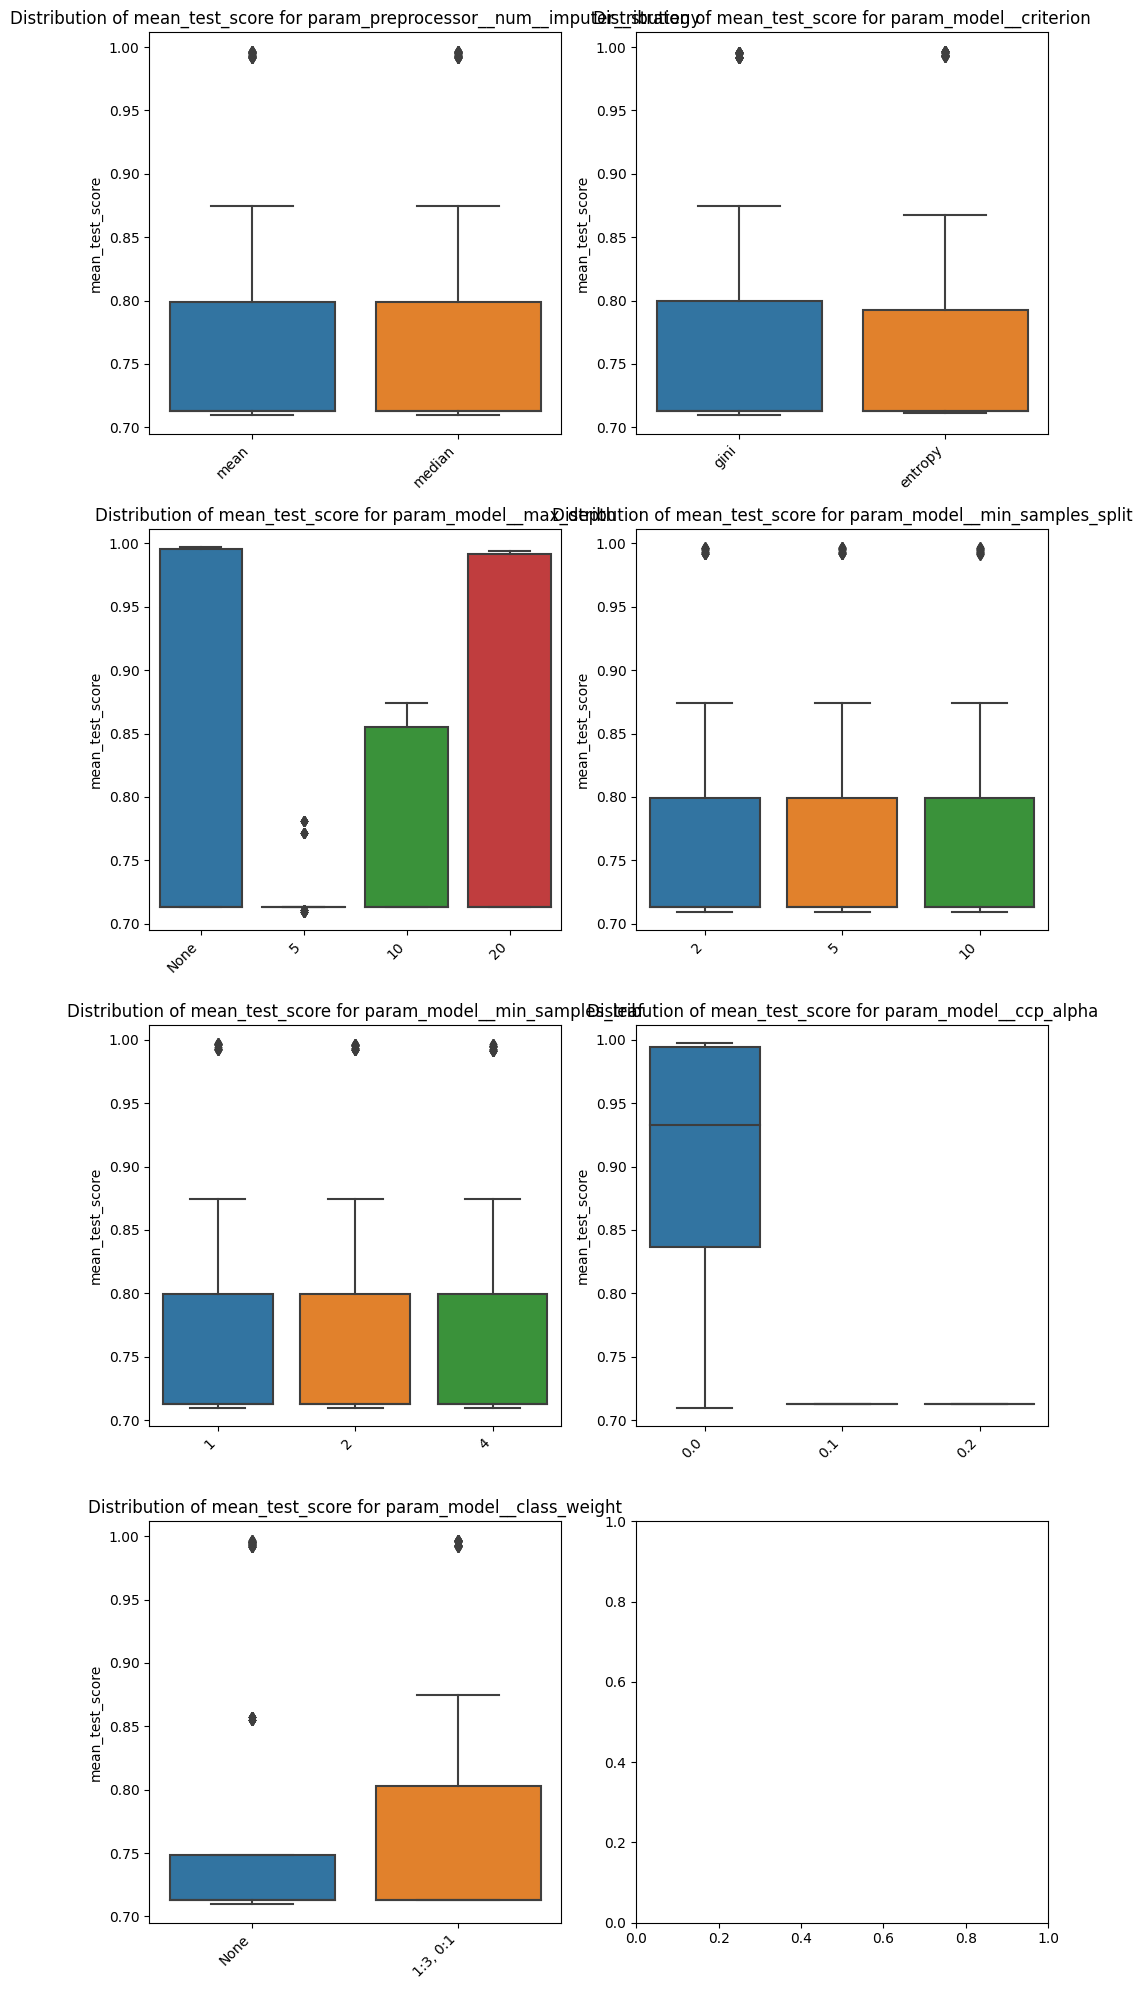

In [129]:
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt

df = all_results.copy()

n_params = len(param_grid.keys())
n_rows = np.ceil(n_params / 2).astype(int)

fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(10, 5 * n_rows))
for i, key in enumerate(param_grid.keys()):
    key = f'param_{key}'
    row, col = divmod(i, 2) 
    sns.boxplot(x=key, y="mean_test_score", data=df, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of mean_test_score for {key}')
    axes[row, col].set_xlabel('')
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

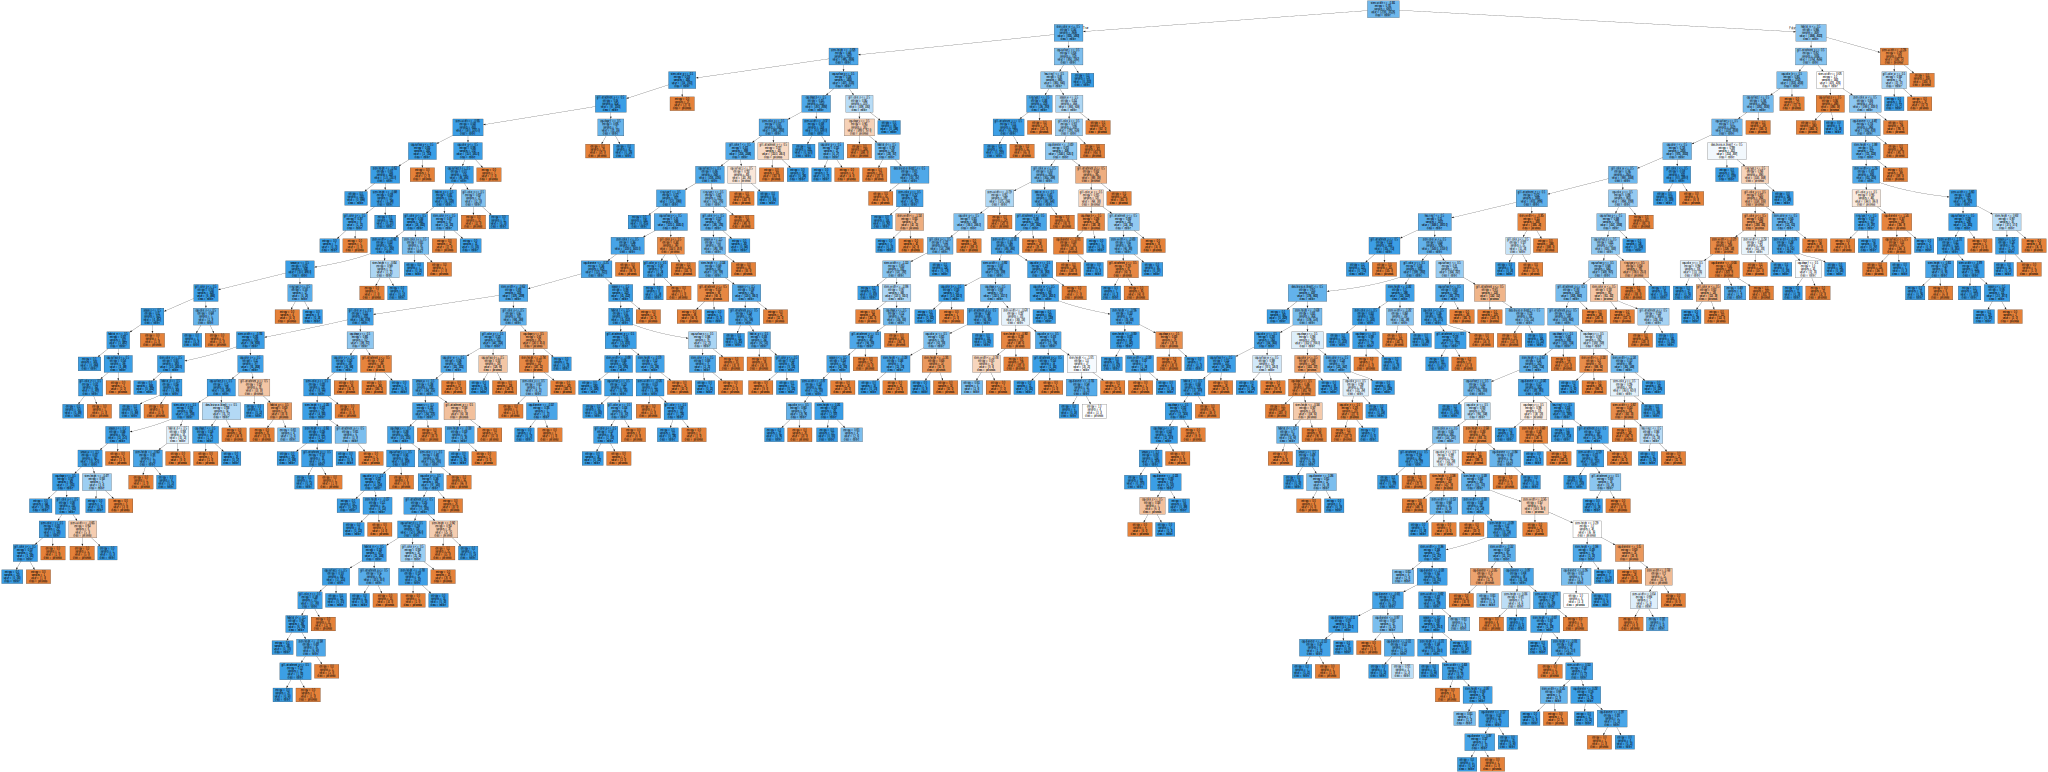

In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz


fig = plt.figure(figsize=(25, 20))
pipeline = result_oh.best_estimator_
clf = pipeline.named_steps['model']

names = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_features)

dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=numeric_features + list(names), 
                                class_names=['poisonous', 'edible'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 

# Save graph
graph.render("mushroom_tree")

graph